In [1]:
import urllib.request
import pyautogui
import time
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from selenium import webdriver
from PIL import Image

In [2]:
driver = webdriver.Chrome('./driver/chromedriver.exe')
# driver = webdriver.Edge("./driver/msedgedriver.exe")
driver.get("https://patrickhlauke.github.io/recaptcha/")
driver.fullscreen_window()
driver.switch_to.default_content()
driver.find_element_by_tag_name("iframe").click()
time.sleep(0.33)

In [3]:
# Find the right iframe in case of multiple redundant tags
iframes = [i for i in driver.find_elements_by_css_selector('[title="recaptcha challenge expires in two minutes"]')]
correctIFrame = None
iFrameIndex = None
for i in iframes:
    driver.switch_to.frame(i)
    buttons = driver.find_elements_by_tag_name("button")
    if len(driver.find_elements_by_tag_name("button")) != 0:
        print("correct iframe found")
        correctIFrame = i
        iFrameIndex = iframes.index(i)
    driver.switch_to.default_content()

correct iframe found


In [4]:
# Find captcha box coordinates
boxX = correctIFrame.location["x"]
boxY = 45 + correctIFrame.location["y"]
driver.switch_to.frame(correctIFrame)

def find_location_of_element(element):
    x = boxX + element.size["width"] / 2 + element.location["x"]
    y = boxY + element.size["height"] / 2 + element.location["y"]
    return x, y

# Find verify button coordinates
verifyX, verifyY = find_location_of_element(driver.find_element_by_id("recaptcha-verify-button"))

# Find reload button coordinates
reloadX, reloadY = find_location_of_element(driver.find_element_by_id("recaptcha-reload-button"))

# Increase Y to compensate for warning message
reloadY += 10
verifyY += 10

In [5]:
# DRIVER INTERACTION FUNCTIONS
def clickIndex(row, column):
    tr_elements = driver.find_elements_by_tag_name("tr")
    td_elements = tr_elements[row].find_elements_by_tag_name("td")
    td_elements[column].click()

def click(x, y):
    pyautogui.moveTo(x, y, duration=0.5)
    pyautogui.click()

def click_verify():
    click(verifyX, verifyY)

def reload():
    click(reloadX, reloadY)

def check_table():
    table_elements = []
    rows = driver.find_elements_by_tag_name("tr")
    for i in rows:
        columns = i.find_elements_by_tag_name("td")
        for j in columns:
            table_elements.append(j)
    return table_elements   

def img_element_with_id(id):
    images = driver.find_elements_by_tag_name("img")
    for i in images:
        if i.get_attribute("class") == "rc-image-tile-33":
            return i

# Get the correct captcha size and type (3x3)
def find_3x3_captcha():
    img_element = img_element_with_id("rc-image-tile-33")
    while img_element is None:
        reload()
        time.sleep(1)
        img_element = img_element_with_id("rc-image-tile-33")
    return check_table()

In [6]:
# IMAGE PROCESSING FUNCTIONS
def show_image(img):
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.array(img))
    plt.show()

def show_image_label(img, label):
    plt.xlabel(label)
    show_image(img)

def process_image(img):
    if img.mode == "RGBA":
        img = img.convert("RGB")
    img = img.resize((100, 100))
    return np.array(img)

def crop_image_and_convert(image):
    width, height = image.size
    grid_width = width // 3
    grid_height = height // 3
    cropped_images = np.zeros((0, 100, 100, 3), dtype=np.uint8)
    for i in range(3):
        for j in range(3):
            left = j * grid_width
            upper = i * grid_height
            right = (j + 1) * grid_width
            lower = (i + 1) * grid_height
            cropped = image.crop((left, upper, right, lower))
            cropped_images = np.concatenate((cropped_images, [process_image(cropped)]))
    return cropped_images

In [7]:
tile_updated = False

def get_table_coords():
    global table_elements
    global table_coords
    table_elements = find_3x3_captcha()
    table_coords = [find_location_of_element(i) for i in table_elements]

def choose_captcha_by_index(index):
    click(table_coords[index][0], table_coords[index][1])

# ROW AND COLUMN STARTS FROM 1 INSTEAD OF 0
def choose_captcha(row, column):
    element_index = (row - 1) * 3 + (column - 1)
    choose_captcha_by_index(element_index)    

In [8]:
# Load model and categories
loaded_model = tf.keras.models.load_model("data/solver/multilabel_model.h5")

label_names = [
    'Bicycle', 'Bridge', 'Bus', 'Car', 'Chimney',
    'Crosswalk', 'Hydrant', 'Motorcycle', 'Other', 'Palm', 'Stair',
    'Traffic Light'
]

multi_label = [
    'Bicycle', 'Bridge', 'Bus', 'Car', 'Crosswalk', 
    'Hydrant', 'Motorcycle', 'Stairs',
    'Traffic Light'
]


captcha_label = [
    ["bicycles", "bicycle", "bike"],
    ["bridges", "bridge"],
    ["buses", "bus"],
    ["cars", "car"],
    ["crosswalks", "crosswalk"],
    ["a fire hydrant", "fire hydrants"],
    ["motorcycles"],
    ["stairs"],
    ["traffic lights"]
]

def decode(label):
    prediction = []
    for i in label:
        if i > 0.2:
            prediction.append(list(label).index(i))
    return prediction

def decode_to_string(label):
    predictions = decode(label)
    string_prediction = []
    for i in predictions:
        to_append = "%s(%lf)" % (multi_label[i], label[i])
        string_prediction.append(to_append)
    return string_prediction

In [9]:
# Download image and convert to numpy
def get_original_image():
    get_table_coords()
    urllib.request.urlretrieve(driver.find_element_by_class_name("rc-image-tile-33").get_attribute("src"), "data/solver/captcha.jpeg")
    return crop_image_and_convert(Image.open("data/solver/captcha.jpeg"))

def check_tile_update(index, images):
    get_table_coords()
    img_element = table_elements[index].find_element_by_tag_name("img")
    if img_element.get_attribute("class") == "rc-image-tile-11":
        file_path = "data/solver/captcha-tile-%d.jpeg" % (index)
        urllib.request.urlretrieve(img_element.get_attribute("src"), file_path)
        images[index] = np.array(Image.open(file_path))
        return True
    return False

def latest_image():
    images = get_original_image()
    debug = 0 
    for i in range(9):
        if check_tile_update(i, images):
            debug += 1
    print("%d images updated" % debug)
    return images

In [10]:
# Prepare and check label to predict
def get_label_index():
    label = driver.find_element_by_tag_name("strong").text
    for i in captcha_label:
        if label in i:
            index = captcha_label.index(i)
            print("Find the", multi_label[index])
            return index
        
def check_warnings():
    class_names = [
        "rc-imageselect-incorrect-response",
        "rc-imageselect-error-select-more",
        "rc-imageselect-error-dynamic-more",
        "rc-imageselect-error-select-something"
    ]
    return [driver.find_element_by_class_name(i).is_displayed() for i in class_names]

In [11]:
def print_grid(images, predictions):
    for i in range(9):
        print(predictions[i])
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        plt.show()

In [12]:
def switch_to_iframe1():
    driver.switch_to.default_content()
    iframes = driver.find_elements_by_css_selector('[title="reCAPTCHA"]')
    driver.switch_to.frame(iframes[iFrameIndex])

def switch_to_iframe2():
    driver.switch_to.default_content()
    iframes = driver.find_elements_by_css_selector('[title="recaptcha challenge expires in two minutes"]')
    driver.switch_to.frame(iframes[iFrameIndex])

def check_success():
    switch_to_iframe1()
    checker = driver.find_elements_by_css_selector('[aria-checked="true"]')
    if len(checker) == 0:
        switch_to_iframe2()
        return False
    else:
        driver.switch_to.default_content()
        return True

In [13]:
def predict_and_click(images, pred_label):
    index_clicked = []
    prediction = loaded_model.predict(images)
    curr_index = 0
    for i in prediction:
        if pred_label in decode(i):
            choose_captcha_by_index(curr_index)
            index_clicked.append(curr_index)
        curr_index += 1
    time.sleep(5)
    return index_clicked, [decode_to_string(i) for i in prediction]

def get_captcha_label():
    label_text = driver.find_element_by_tag_name("strong").text
    for i in captcha_label:
        if label_text in i:
            return captcha_label.index(i)
        
def submit():
    global attempts, success
    attempts += 1
    click_verify()
    time.sleep(4)
    get_table_coords()
    if check_success() == False:
        time.sleep(1.5)
        solve_captcha(latest_image())
    else:
        success += 1

def solve_captcha(images, index_clicked=[]):
    get_table_coords()
    prediction_label = get_captcha_label()
    if len(index_clicked) != 0:
        for i in index_clicked:
            check_tile_update(i, images)
    index_clicked, predictions = predict_and_click(images, prediction_label)
    print_grid(images, predictions)
    print("INDEX CLICKED:", index_clicked)
    if len(index_clicked) > 0:
        solve_captcha(images, index_clicked=index_clicked)
    else:
        get_table_coords()
        submit()

correct iframe found
1/1 [==============================] - 4s 4s/step
['Bridge(0.482170)', 'Car(0.470369)']


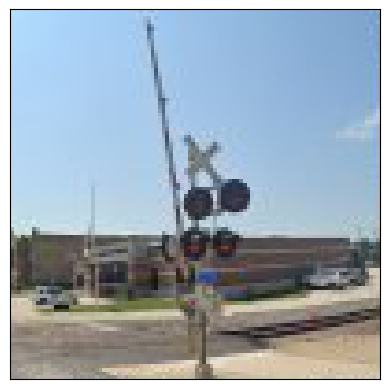

['Hydrant(1.000000)']


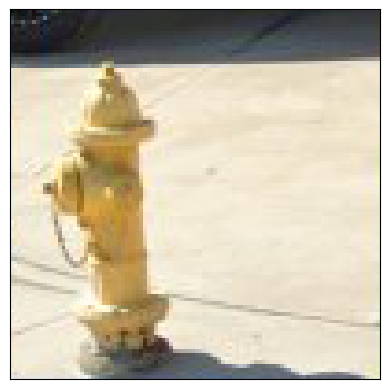

['Hydrant(1.000000)']


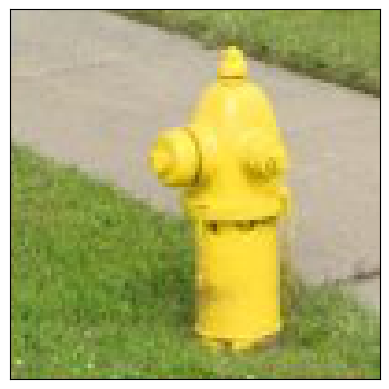

['Bicycle(0.250976)', 'Motorcycle(0.239126)']


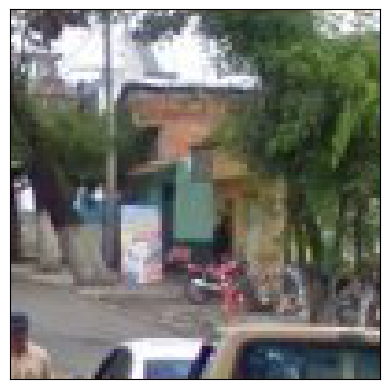

['Bus(0.293795)', 'Car(0.426608)']


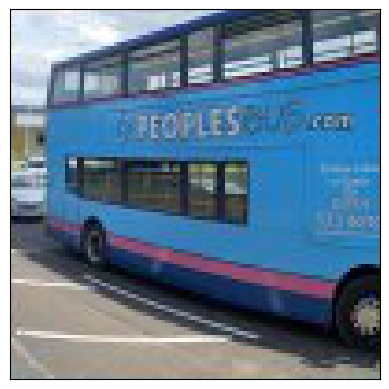

['Bicycle(0.216108)', 'Car(0.810691)', 'Motorcycle(0.565132)']


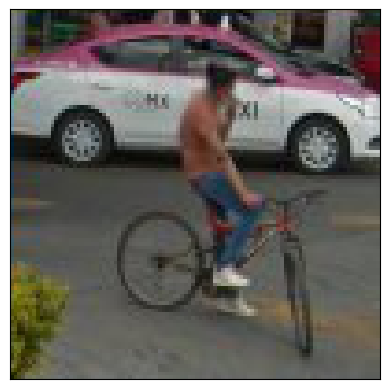

['Hydrant(0.999995)']


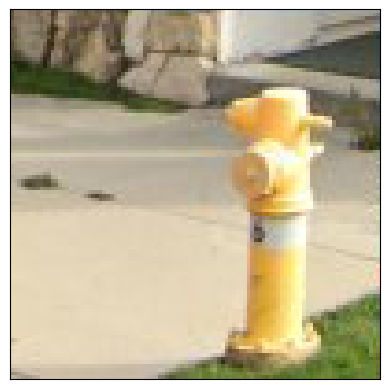

['Bridge(0.928694)', 'Car(0.996413)']


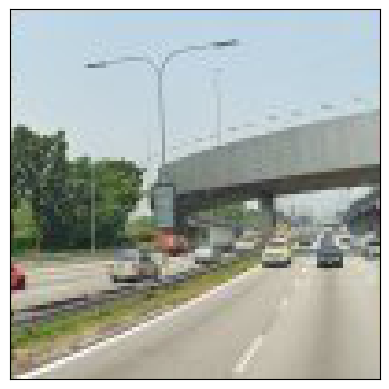

['Stairs(0.451025)']


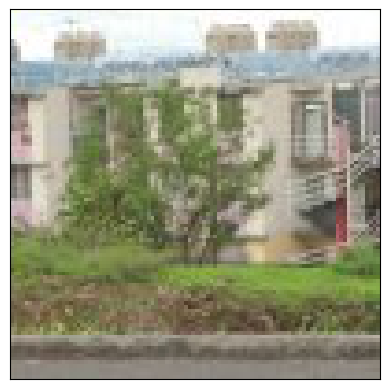

INDEX CLICKED: [1, 2, 6]
1/1 [==============================] - 0s 19ms/step
['Bridge(0.482170)', 'Car(0.470369)']


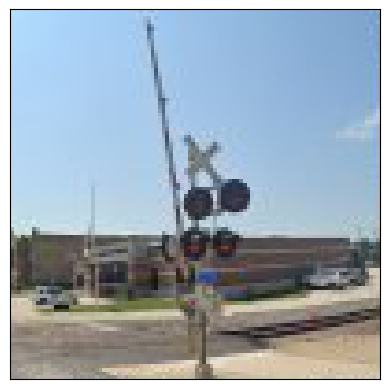

['Hydrant(0.999369)']


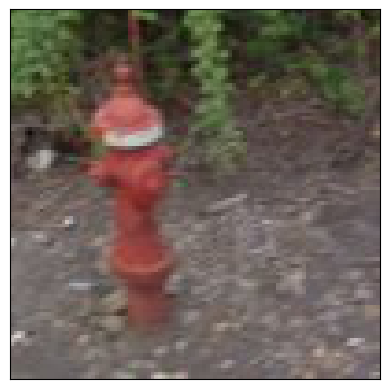

['Car(0.327262)']


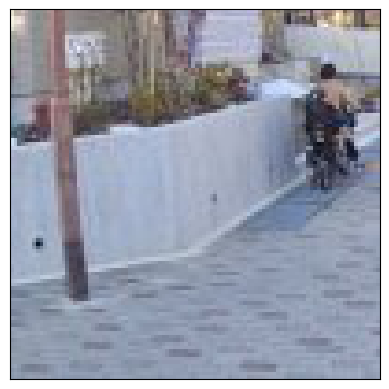

['Bicycle(0.250976)', 'Motorcycle(0.239126)']


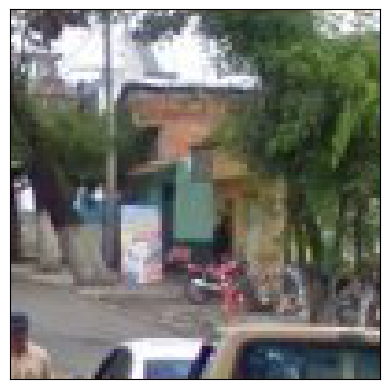

['Bus(0.293795)', 'Car(0.426608)']


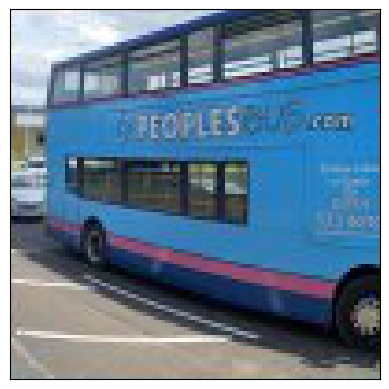

['Bicycle(0.216108)', 'Car(0.810691)', 'Motorcycle(0.565132)']


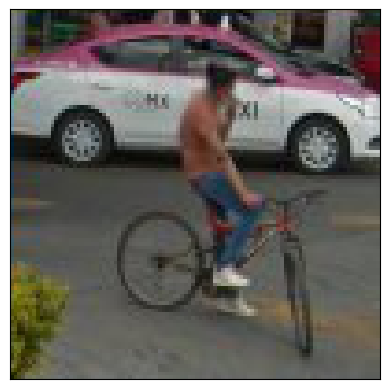

['Hydrant(0.979665)']


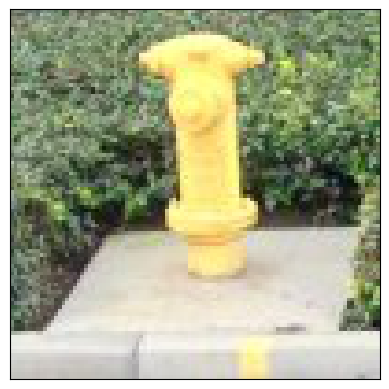

['Bridge(0.928694)', 'Car(0.996413)']


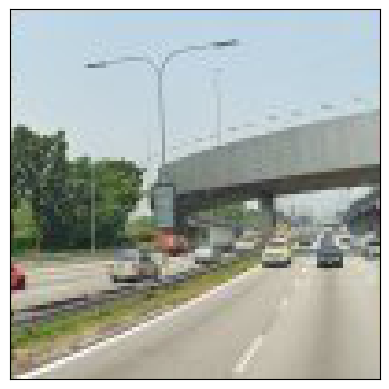

['Stairs(0.451025)']


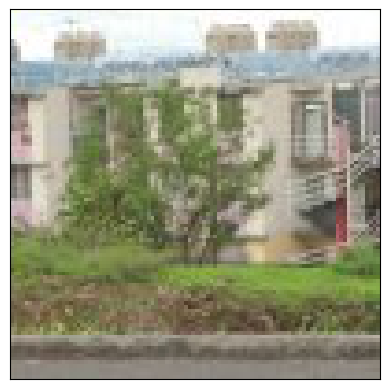

INDEX CLICKED: [1, 6]
1/1 [==============================] - 0s 19ms/step
['Bridge(0.482170)', 'Car(0.470369)']


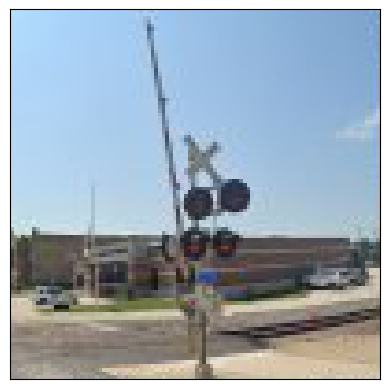

['Bicycle(0.396012)', 'Car(0.405129)', 'Motorcycle(0.402127)']


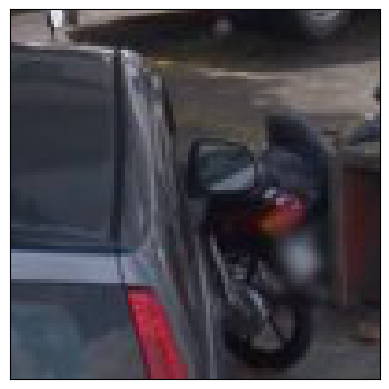

['Car(0.327262)']


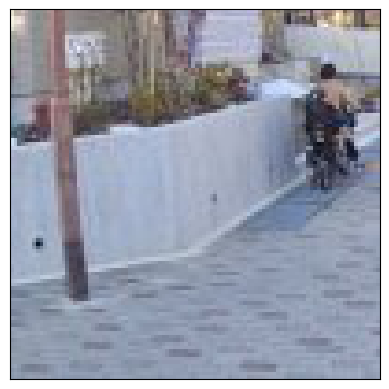

['Bicycle(0.250976)', 'Motorcycle(0.239126)']


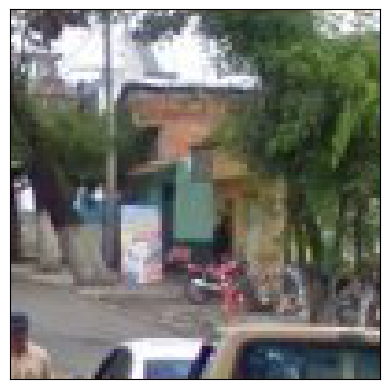

['Bus(0.293795)', 'Car(0.426608)']


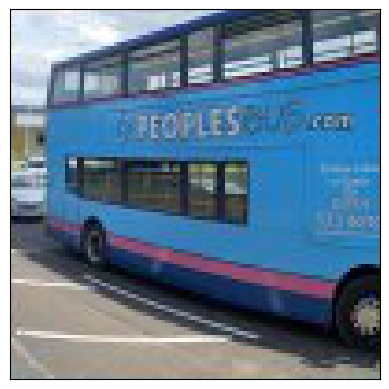

['Bicycle(0.216108)', 'Car(0.810691)', 'Motorcycle(0.565132)']


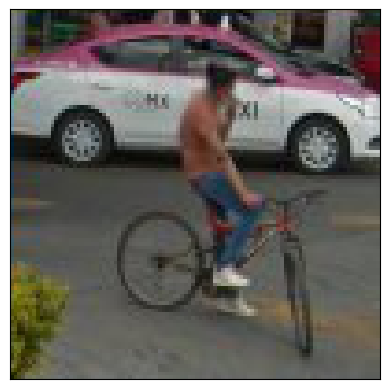

['Bicycle(0.479127)']


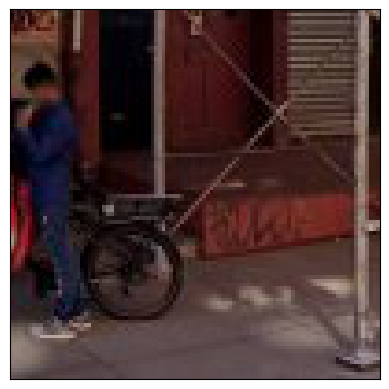

['Bridge(0.928694)', 'Car(0.996413)']


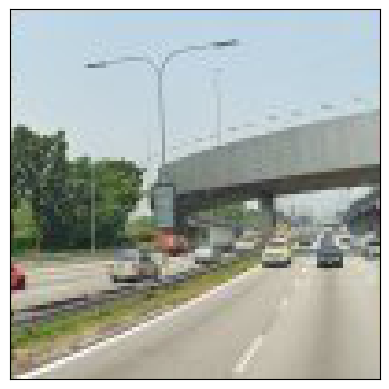

['Stairs(0.451025)']


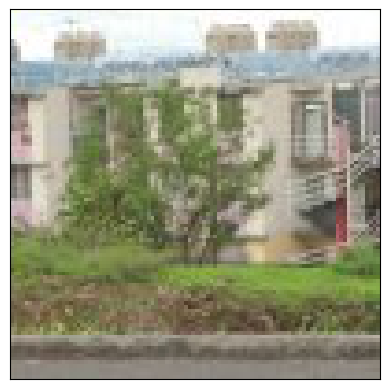

INDEX CLICKED: []
0 images updated
1/1 [==============================] - 0s 19ms/step
['Crosswalk(0.845003)']


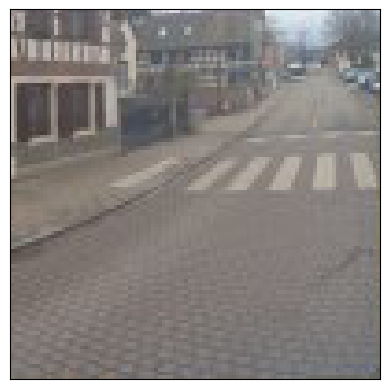

[]


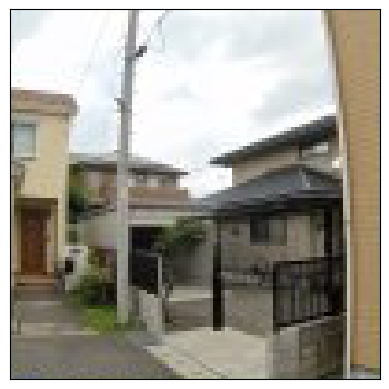

['Car(0.987930)', 'Crosswalk(0.999631)']


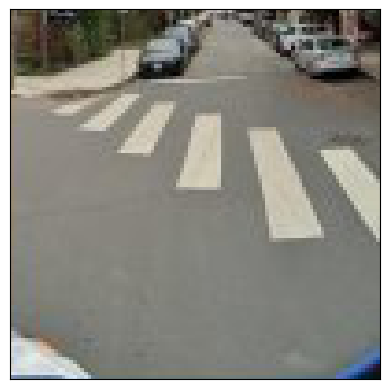

['Bicycle(0.633754)']


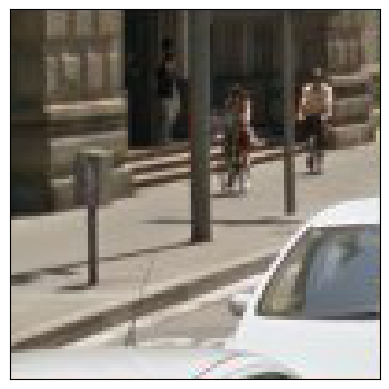

['Bridge(0.691271)']


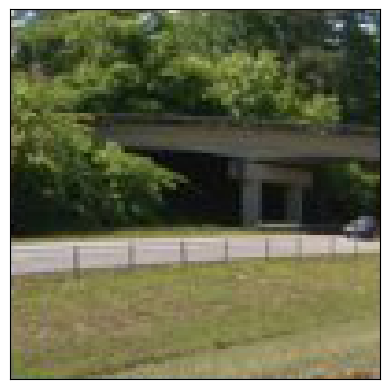

['Bridge(0.995351)']


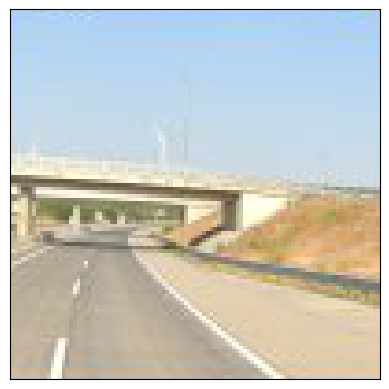

['Hydrant(0.779184)']


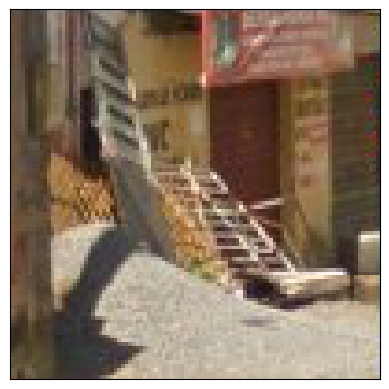

['Car(0.997812)', 'Crosswalk(0.953535)', 'Traffic Light(0.412123)']


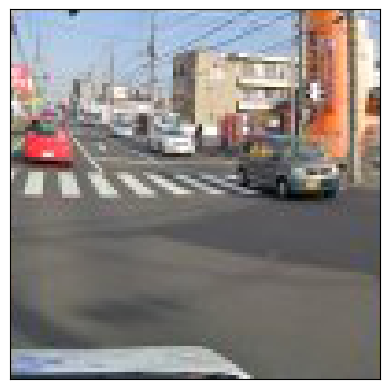

['Bridge(0.447198)', 'Car(0.982758)']


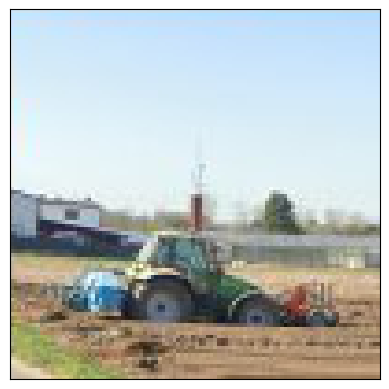

INDEX CLICKED: [0, 2, 7]
1/1 [==============================] - 0s 18ms/step
['Crosswalk(0.999683)']


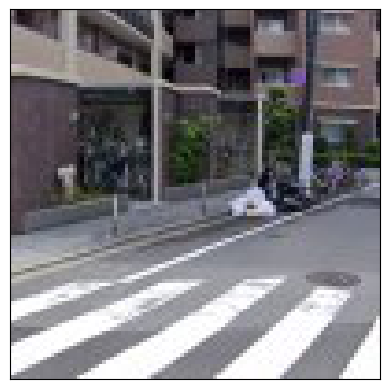

[]


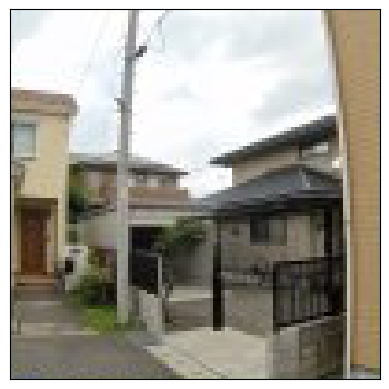

['Bicycle(0.503529)', 'Car(0.411299)', 'Motorcycle(0.582010)']


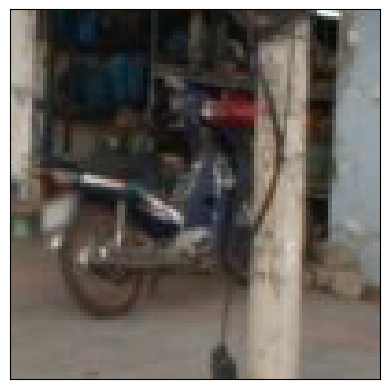

['Bicycle(0.633754)']


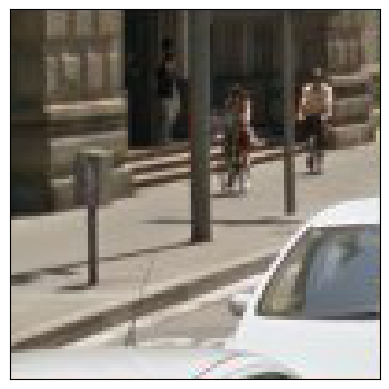

['Bridge(0.691271)']


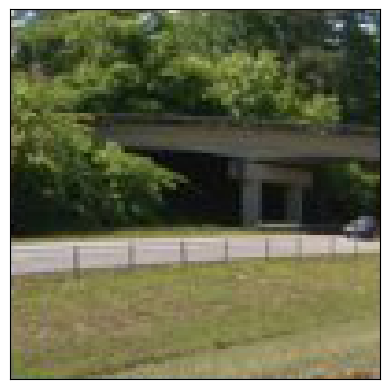

['Bridge(0.995351)']


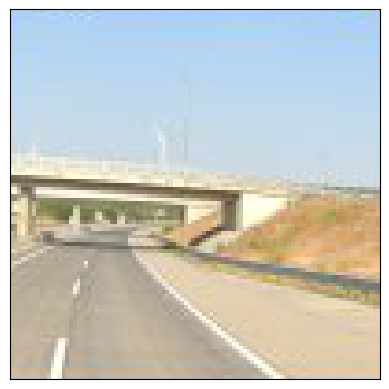

['Hydrant(0.779184)']


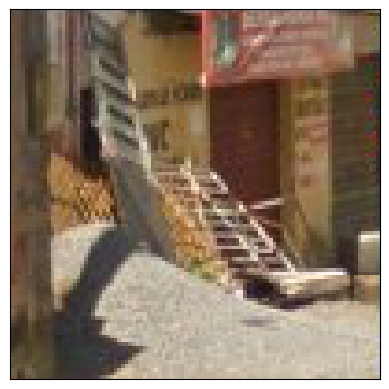

['Bicycle(0.443187)', 'Bridge(0.242518)', 'Car(0.665749)', 'Motorcycle(0.608046)']


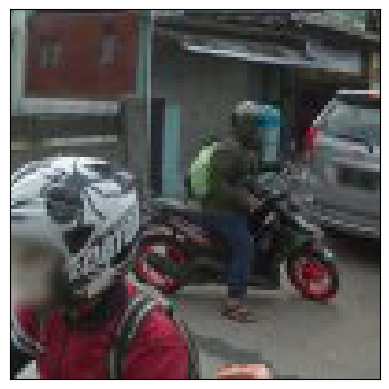

['Bridge(0.447198)', 'Car(0.982758)']


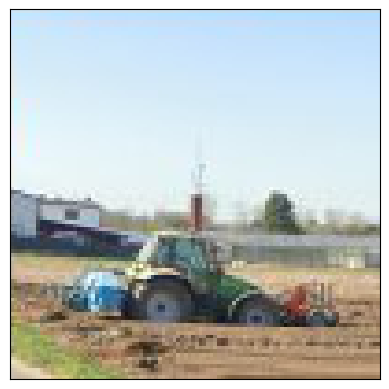

INDEX CLICKED: [0]
1/1 [==============================] - 0s 19ms/step
['Crosswalk(0.956170)']


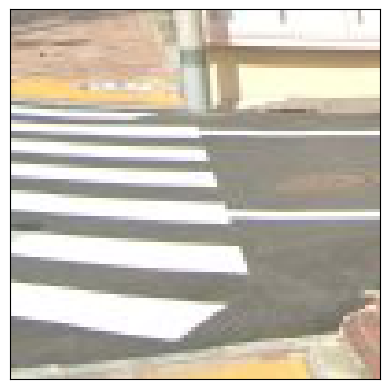

[]


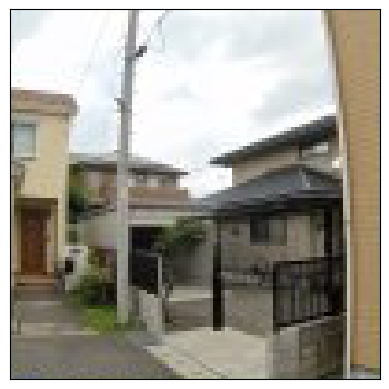

['Bicycle(0.503529)', 'Car(0.411299)', 'Motorcycle(0.582010)']


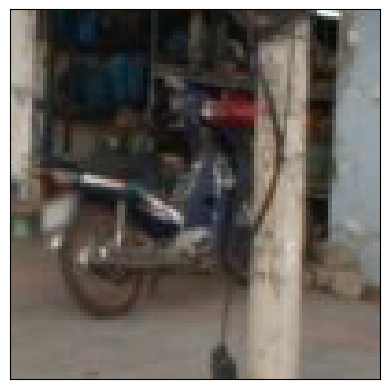

['Bicycle(0.633754)']


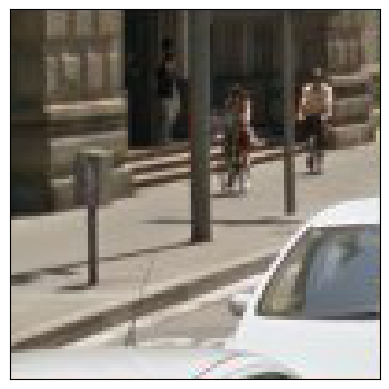

['Bridge(0.691271)']


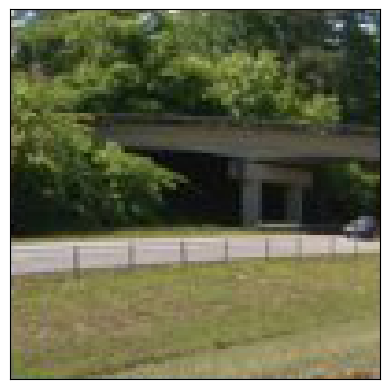

['Bridge(0.995351)']


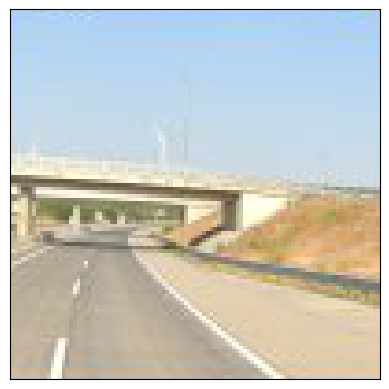

['Hydrant(0.779184)']


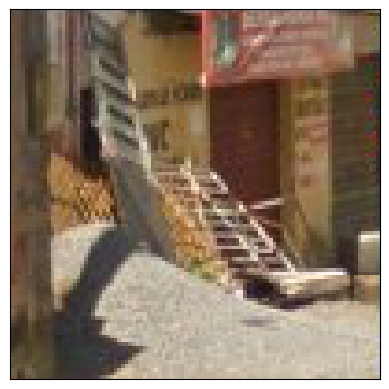

['Bicycle(0.443187)', 'Bridge(0.242518)', 'Car(0.665749)', 'Motorcycle(0.608046)']


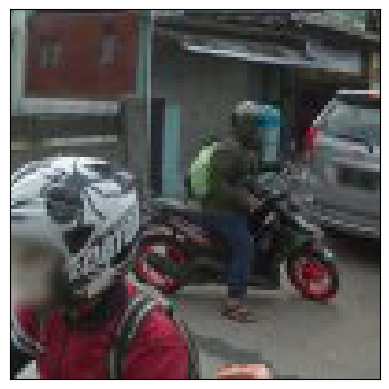

['Bridge(0.447198)', 'Car(0.982758)']


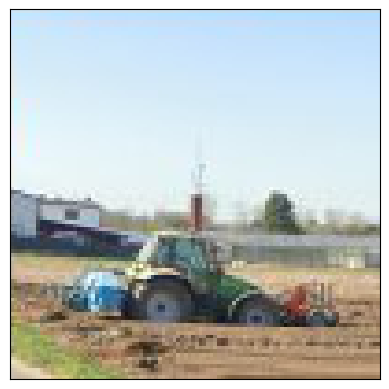

INDEX CLICKED: [0]
1/1 [==============================] - 0s 20ms/step
['Crosswalk(0.999897)']


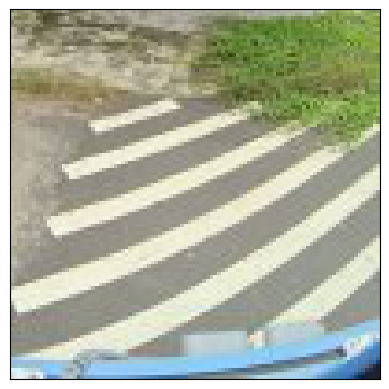

[]


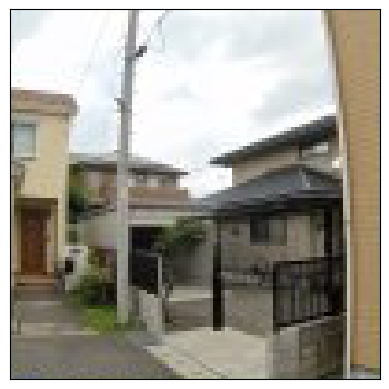

['Bicycle(0.503529)', 'Car(0.411299)', 'Motorcycle(0.582010)']


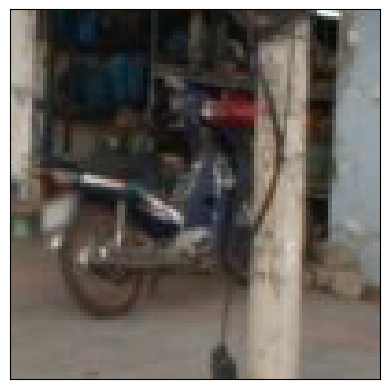

['Bicycle(0.633754)']


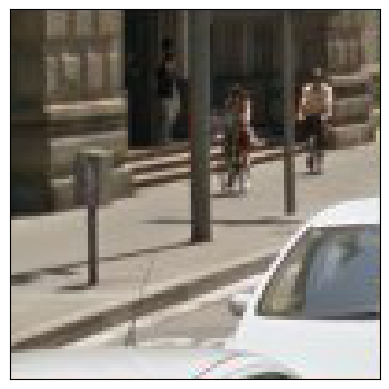

['Bridge(0.691271)']


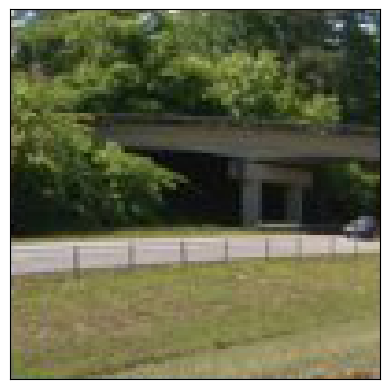

['Bridge(0.995351)']


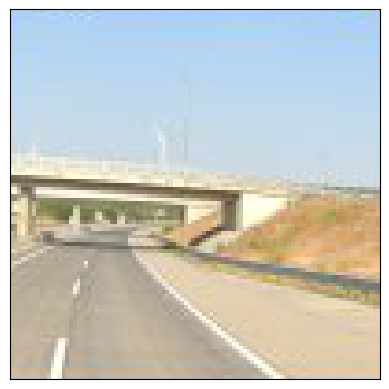

['Hydrant(0.779184)']


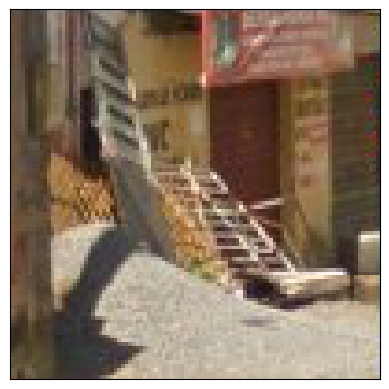

['Bicycle(0.443187)', 'Bridge(0.242518)', 'Car(0.665749)', 'Motorcycle(0.608046)']


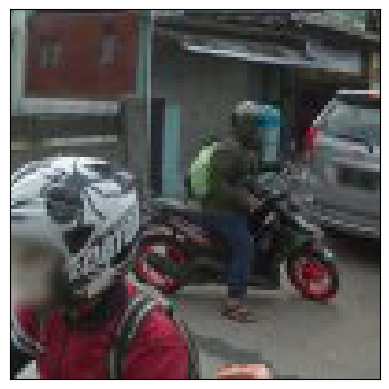

['Bridge(0.447198)', 'Car(0.982758)']


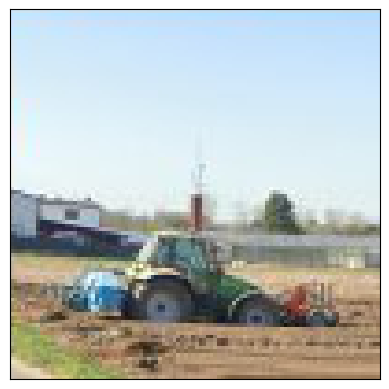

INDEX CLICKED: [0]
1/1 [==============================] - 0s 18ms/step
['Traffic Light(0.999844)']


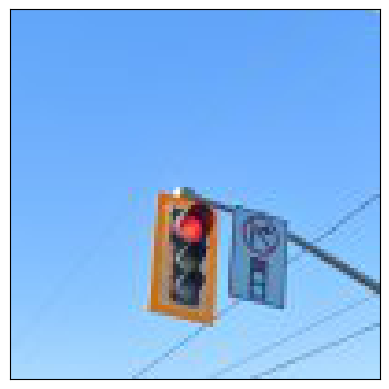

[]


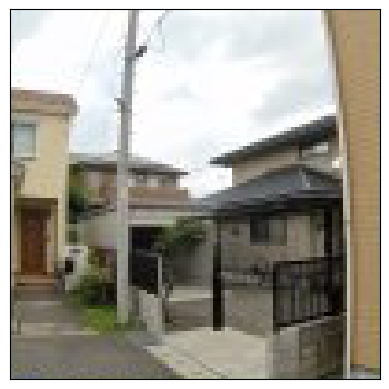

['Bicycle(0.503529)', 'Car(0.411299)', 'Motorcycle(0.582010)']


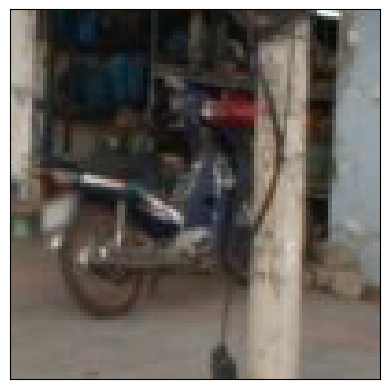

['Bicycle(0.633754)']


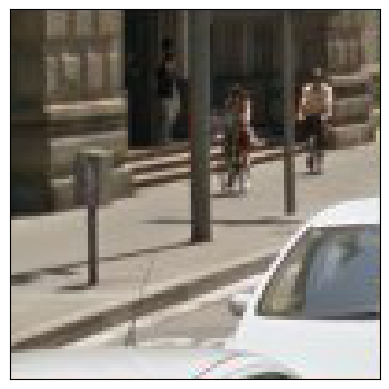

['Bridge(0.691271)']


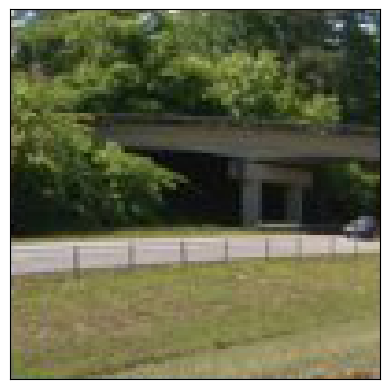

['Bridge(0.995351)']


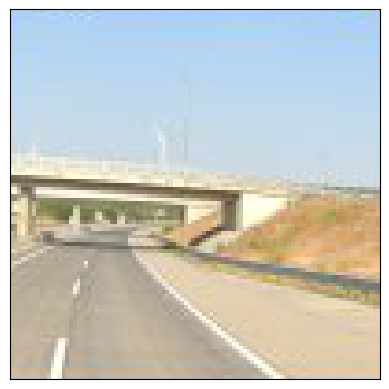

['Hydrant(0.779184)']


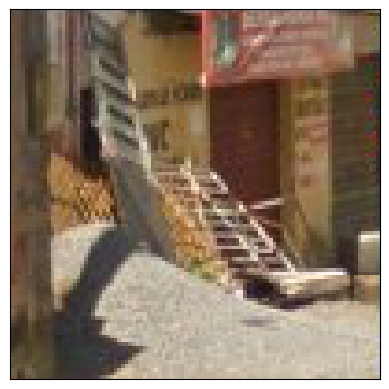

['Bicycle(0.443187)', 'Bridge(0.242518)', 'Car(0.665749)', 'Motorcycle(0.608046)']


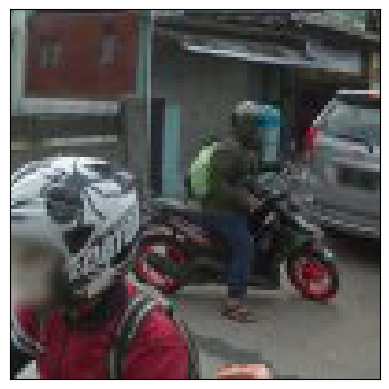

['Bridge(0.447198)', 'Car(0.982758)']


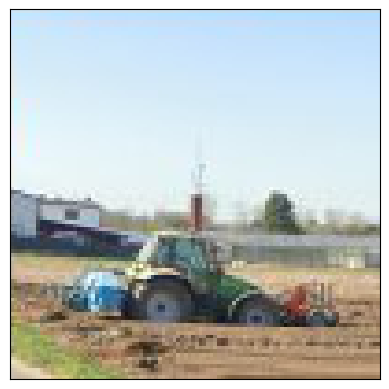

INDEX CLICKED: []


In [14]:
attempts = 0
success = 0
driver.quit()
while True:
    driver = webdriver.Chrome('./driver/chromedriver.exe')
    try:
        # driver = webdriver.Edge("./driver/msedgedriver.exe")
        driver.get("https://patrickhlauke.github.io/recaptcha/")
        driver.fullscreen_window()
        driver.switch_to.default_content()
        driver.find_element_by_tag_name("iframe").click()
        time.sleep(0.33)
        iframes = [i for i in driver.find_elements_by_css_selector('[title="recaptcha challenge expires in two minutes"]')]
        correctIFrame = None
        iFrameIndex = None
        for i in iframes:
            driver.switch_to.frame(i)
            buttons = driver.find_elements_by_tag_name("button")
            if len(driver.find_elements_by_tag_name("button")) != 0:
                print("correct iframe found")
                correctIFrame = i
                iFrameIndex = iframes.index(i)
            driver.switch_to.default_content()
        driver.switch_to.frame(correctIFrame)
        solve_captcha(get_original_image())
        driver.quit()
    except:
        driver.quit()
    if attempts > 10:
        break
print("Attempts = %d\nSuccess Rate = %.2f", (attempts, success/attempts))

In [ ]:
# Code to print predicted images:
# for i in range(len(to_predict)):
#     show_image_label(to_predict[i], decode(predicted[i]))